--- Importing Libraries ---
Multiple GPUs found: 2. Multi-GPU strategy will be used.

--- Setting Global Parameters ---

--- Defining All Helper Functions ---
All functions defined successfully.

--- Starting Full Workflow ---

[1/5] Preparing Data...
Data split into: Train Triplets (12903), Validation Triplets (2277), Test Pairs (30360)


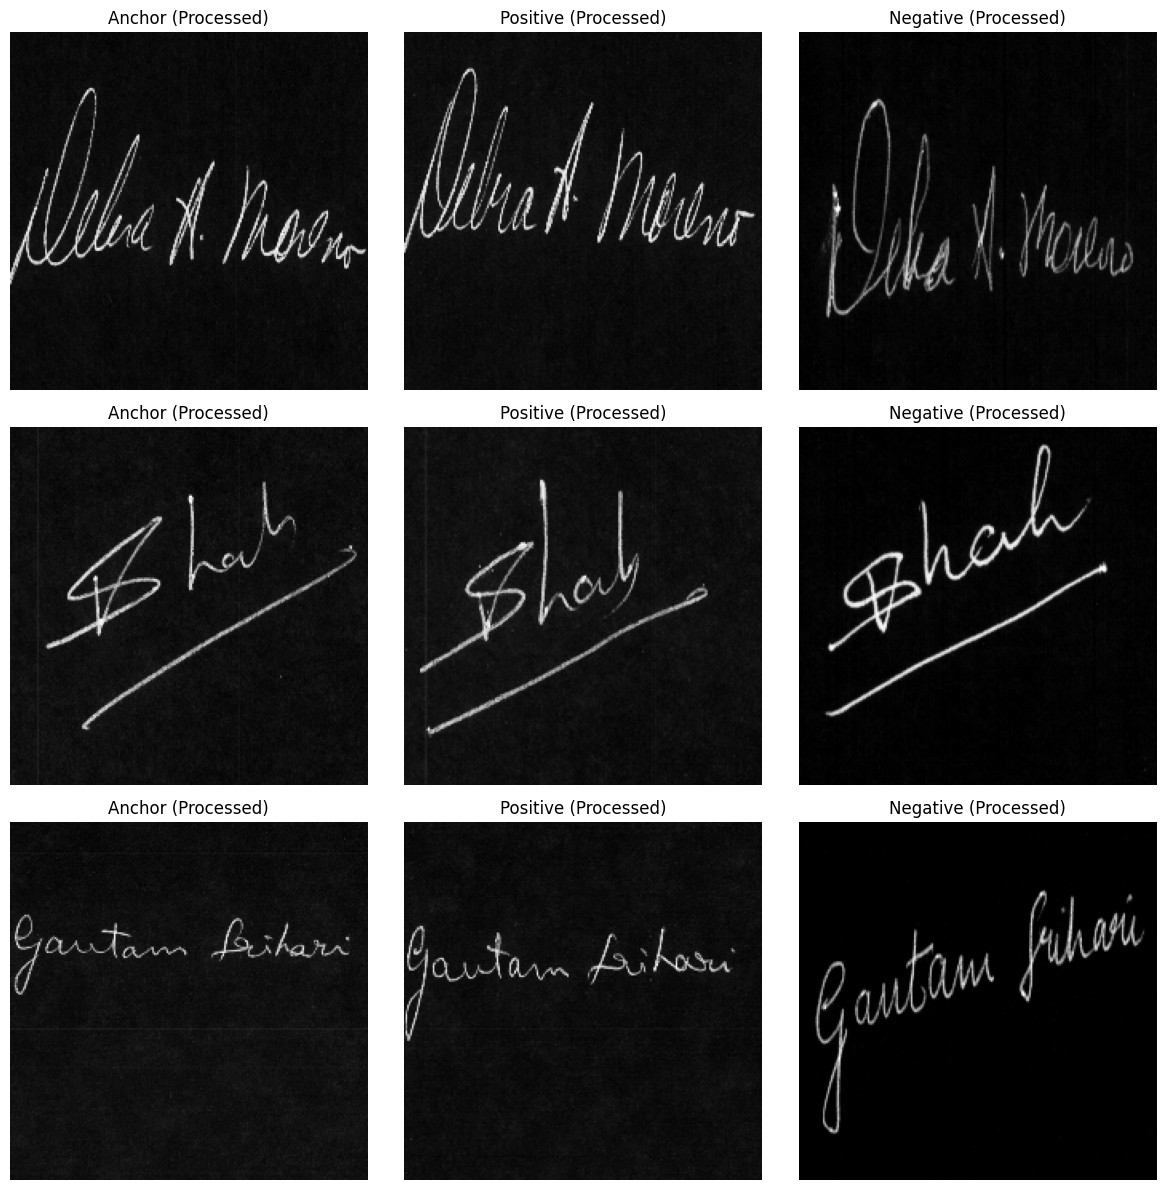


Creating tf.data.Dataset objects...

[2/5] Building and Compiling Model...
Number of devices: 2


Model: "triplet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ anchor_input (InputLayer) │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positive_input            │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ negative_input            │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_model           │ (None, 128)            │     40,285,504 │ anchor_input[0][0],    │
│ (Sequential)              │                        │                │ positive_input[0][0],  │
│                           │                        │                │ negative_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 384)            │              0 │ embedding_model[0][0], │
│ (Concatenate)             │                        │                │ embedding_model[1][0], │
│                           │                        │                │ embedding_model[2][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 40,285,504 (153.68 MB)

 Trainable params: 40,281,472 (153.66 MB)

 Non-trainable params: 4,032 (15.75 KB)


[3/5] Starting Model Training...


E0000 00:00:1750252581.655616      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/triplet_model_1/embedding_model_1/dropout_9_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 79.9038
Epoch 1: val_loss improved from inf to 0.50685, saving model to /kaggle/working/output_triplet_signet_cnn/best_triplet_model.h5
Epoch 01: loss: 79.7832 - val_loss: 0.5068 - learning_rate: 0.0001
100/100 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - loss: 79.9026 - val_loss: 0.5068 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.

[4/5] Evaluating Best Embedding Model...
Optimal Threshold found on Test Set: 0.5218

[5/5] Generating Final Report on TEST Set...


In [ ]:
# ==============================================================================
#      FINAL, VERIFIED SCRIPT with Multi-GPU Training Re-enabled
# ==============================================================================

# ------------------------------------------------------------------------------
# IMPORTS
# ------------------------------------------------------------------------------
print("--- Importing Libraries ---")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, roc_auc_score
from sklearn.manifold import TSNE

from itertools import combinations
import importlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, GlobalAveragePooling2D, Dropout, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

gpu_devices = tf.config.list_physical_devices('GPU')
if len(gpu_devices) > 1:
    print(f"Multiple GPUs found: {len(gpu_devices)}. Multi-GPU strategy will be used.")
elif len(gpu_devices) == 1:
    print(f"Single GPU found: {gpu_devices[0]}")
else:
    print("WARNING: GPU not found. Training on CPU.")


# ------------------------------------------------------------------------------
# GLOBAL PARAMETERS
# ------------------------------------------------------------------------------
print("\n--- Setting Global Parameters ---")
BACKBONE_MODEL = 'signet_cnn'   #custom_cnn, signet_cnn, 'MobileNetV2', 'ResNet50', 'Xception', 'InceptionV3'
IMG_SIZE = 224
# Set a larger global batch size for multi-GPU training
# This will be split across devices (e.g., 128 / 2 GPUs = 64 per GPU)
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
TRIPLET_MARGIN = 0.5

DATASET_PATH = "/kaggle/input/cedar-2/2"
OUTPUT_PATH = f"/kaggle/working/output_triplet_{BACKBONE_MODEL}/"
if not os.path.exists(OUTPUT_PATH): os.makedirs(OUTPUT_PATH)


# ------------------------------------------------------------------------------
# ALL HELPER FUNCTIONS
# ------------------------------------------------------------------------------
print("\n--- Defining All Helper Functions ---")

def create_triplets(dataset_path):
    triplets, users = [], [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    for user in users:
        genuine_path, forged_path = os.path.join(dataset_path, user, 'genuine'), os.path.join(dataset_path, user, 'forged')
        if not (os.path.exists(genuine_path) and os.path.exists(forged_path)): continue
        genuine_images = [os.path.join(genuine_path, f) for f in os.listdir(genuine_path)]
        forged_images = [os.path.join(forged_path, f) for f in os.listdir(forged_path)]
        if len(genuine_images) < 2 or len(forged_images) < 1: continue
        for anchor, positive in combinations(genuine_images, 2):
            triplets.append([anchor, positive, random.choice(forged_images)])
    return np.array(triplets)

def create_image_pairs(dataset_path):
    image_pairs, labels, users = [], [], [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    for user in users:
        genuine_path, forged_path = os.path.join(dataset_path, user, 'genuine'), os.path.join(dataset_path, user, 'forged')
        if not (os.path.exists(genuine_path) and os.path.exists(forged_path)): continue
        genuine_images = [os.path.join(genuine_path, f) for f in os.listdir(genuine_path)]
        forged_images = [os.path.join(forged_path, f) for f in os.listdir(forged_path)]
        if not genuine_images or not forged_images: continue
        for anchor, positive in combinations(genuine_images, 2):
            image_pairs.append([anchor, positive]); labels.append(1)
            if forged_images: image_pairs.append([anchor, random.choice(forged_images)]); labels.append(0)
    return np.array(image_pairs), np.array(labels)

def preview_processed_triplets(triplets, num_previews=5):
    plt.figure(figsize=(12, 4 * num_previews))
    if len(triplets) < num_previews: num_previews = len(triplets)
    if num_previews == 0: return
    indices = random.sample(range(len(triplets)), num_previews)
    for i, idx in enumerate(indices):
        for j, (path, title) in enumerate(zip(triplets[idx], ["Anchor", "Positive", "Negative"])):
            try:
                processed_img = load_image_tf(path).numpy()
                vis_img = (processed_img - processed_img.min()) / (processed_img.max() - processed_img.min())
                plt.subplot(num_previews, 3, i * 3 + j + 1)
                plt.imshow(vis_img, cmap='gray')
                plt.title(f"{title} (Processed)")
                plt.axis('off')
            except Exception as e:
                print(f"Could not process or display image {path}: {e}")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'triplet_previews_processed.png'))
    plt.show()

def get_augmenter():
    return Sequential([tf.keras.layers.RandomRotation(0.05, fill_mode='constant', fill_value=0.0),
                       tf.keras.layers.RandomTranslation(0.08, 0.08, fill_mode='constant', fill_value=0.0),
                       tf.keras.layers.RandomZoom(0.08, fill_mode='constant', fill_value=0.0)], name='augmenter')

def load_image_tf(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0
    img = 1.0 - img
    return img

def load_triplet_and_label(triplet):
    return (load_image_tf(triplet[0]), load_image_tf(triplet[1]), load_image_tf(triplet[2])), 0.0

def load_pair_and_label(image_pair, label):
    return (load_image_tf(image_pair[0]), load_image_tf(image_pair[1])), label
    
def triplet_loss(_, y_pred):
    anchor, positive, negative = y_pred[:, 0:128], y_pred[:, 128:256], y_pred[:, 256:384]
    positive_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    negative_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    return tf.reduce_mean(tf.maximum(positive_dist - negative_dist + TRIPLET_MARGIN, 0.0))

def get_signet_cnn(input_shape):
    return Sequential([
        Input(shape=input_shape), Conv2D(96, 11, 2), BatchNormalization(), ReLU(), MaxPooling2D(3, 2),
        Conv2D(256, 5, padding='same'), BatchNormalization(), ReLU(), MaxPooling2D(3, 2), Dropout(0.3),
        Conv2D(384, 3, padding='same'), BatchNormalization(), ReLU(), Conv2D(256, 3, padding='same'), BatchNormalization(), ReLU(),
        MaxPooling2D(3, 2), Dropout(0.3), Flatten(), Dense(1024), BatchNormalization(), ReLU(), Dropout(0.5), Dense(128)
    ], name="embedding_model")

def get_embedding_model(input_shape):
    # This logic can be expanded to re-include other models if needed
    return get_signet_cnn(input_shape)

def build_triplet_model(input_shape):
    inputs = [Input(input_shape, name=n) for n in ['anchor_input', 'positive_input', 'negative_input']]
    embedding_model = get_embedding_model(input_shape)
    embeddings = [embedding_model(i) for i in inputs]
    output = tf.keras.layers.Concatenate(axis=-1)(embeddings)
    return Model(inputs=inputs, outputs=output, name='triplet_model')

def find_optimal_threshold(y_true, y_pred_distances):
    fpr, tpr, thresholds = roc_curve(y_true, 1 - np.nan_to_num(y_pred_distances))
    return 1 - thresholds[np.argmax(tpr - fpr)]

class EpochSummaryLogger(keras.callbacks.Callback):
    def __init__(self, filepath):
        super(EpochSummaryLogger, self).__init__()
        self.filepath = filepath
        # Clear the file at the beginning of training
        with open(self.filepath, 'w') as f:
            f.write("Epoch Training Summary\n")
            f.write("="*30 + "\n")

    def on_epoch_end(self, epoch, logs=None):
        # Format the log string
        summary_str = f"Epoch {epoch+1:02d}: "
        summary_str += " - ".join([f"{k}: {v:.4f}" for k, v in logs.items()])
        
        # Print to console
        print(summary_str)
        
        # Save to file
        with open(self.filepath, 'a') as f:
            f.write(summary_str + "\n")

print("All functions defined successfully.")


# ------------------------------------------------------------------------------
# WORKFLOW (DATA PREP, COMPILE, TRAIN, EVALUATE)
# ------------------------------------------------------------------------------
print("\n--- Starting Full Workflow ---")

# 1. Prepare Data
print("\n[1/5] Preparing Data...")
all_triplets = create_triplets(DATASET_PATH)
if len(all_triplets) == 0: raise ValueError("No triplets were created. Check DATASET_PATH.")
p = np.random.permutation(len(all_triplets))
train_end = int(0.85 * len(p))
train_triplets, val_triplets = all_triplets[p[:train_end]], all_triplets[p[train_end:]]
image_pairs, labels = create_image_pairs(DATASET_PATH)
print(f"Data split into: Train Triplets ({len(train_triplets)}), Validation Triplets ({len(val_triplets)}), Test Pairs ({len(image_pairs)})")
preview_processed_triplets(train_triplets, num_previews=3)

# 2. Create High-Performance tf.data.Dataset Pipelines
print("\nCreating tf.data.Dataset objects...")
AUTOTUNE = tf.data.AUTOTUNE
augmenter = get_augmenter()
def augment(inputs, label):
    return (augmenter(inputs[0], training=True), augmenter(inputs[1], training=True), augmenter(inputs[2], training=True)), label

triplet_signature = ((tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32),)*3, tf.TensorSpec(shape=(), dtype=tf.float32))
# --- VITAL FOR MULTI-GPU: Add drop_remainder=True ---
train_dataset = tf.data.Dataset.from_tensor_slices(train_triplets).shuffle(len(train_triplets)).map(load_triplet_and_label, AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).map(augment, AUTOTUNE).prefetch(AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(val_triplets).map(load_triplet_and_label, AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)

# 3. Build and Compile Model with Multi-GPU Strategy
print("\n[2/5] Building and Compiling Model...")
# --- NEW: Set up Multi-GPU Strategy ---
strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')

with strategy.scope():
    triplet_model = build_triplet_model((IMG_SIZE, IMG_SIZE, 1))
    optimizer = Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
    triplet_model.compile(loss=triplet_loss, optimizer=optimizer)
triplet_model.summary()

# 4. Train the Model
print("\n[3/5] Starting Model Training...")
checkpoint_filepath = os.path.join(OUTPUT_PATH, 'best_triplet_model.h5')
summary_log_filepath = os.path.join(OUTPUT_PATH, 'epoch_summary.log')
callbacks = [
    ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    EpochSummaryLogger(filepath=summary_log_filepath)
]
history = triplet_model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=val_dataset, callbacks=callbacks)

# 5. Evaluate the Model
print("\n[4/5] Evaluating Best Embedding Model...")
# To evaluate, we create a temporary model with the saved weights OUTSIDE the strategy scope
# This is a common practice for inference.
triplet_model.load_weights(checkpoint_filepath)
embedding_model = triplet_model.get_layer('embedding_model')

test_dataset = tf.data.Dataset.from_tensor_slices((image_pairs, labels)).map(load_pair_and_label, AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
y_true_labels_test, y_pred_distances_test = [], []
for images, labels_batch in test_dataset:
    embeddings1 = embedding_model.predict(images[0], verbose=0)
    embeddings2 = embedding_model.predict(images[1], verbose=0)
    distances = tf.sqrt(tf.reduce_sum(tf.square(embeddings1 - embeddings2), axis=-1))
    y_pred_distances_test.extend(distances.numpy())
    y_true_labels_test.extend(labels_batch.numpy())

y_true_labels_test, y_pred_distances_test = np.array(y_true_labels_test), np.array(y_pred_distances_test)
optimal_threshold = find_optimal_threshold(y_true_labels_test, y_pred_distances_test)
print(f"Optimal Threshold found on Test Set: {optimal_threshold:.4f}")

# 6. Final evaluation reporting
print("\n[5/5] Generating Final Report on TEST Set...")
y_pred_binary_test = (y_pred_distances_test < optimal_threshold).astype(int)

# 7. Generate and display all reports
pd.DataFrame(history.history).plot(figsize=(10, 6)); plt.title(f'Model Training History ({BACKBONE_MODEL})'); plt.ylabel('Loss'); plt.xlabel('Epoch'); plt.grid(True); plt.legend(history.history.keys());
plt.savefig(os.path.join(OUTPUT_PATH, 'training_history.png')); plt.show()

cm = confusion_matrix(y_true_labels_test, y_pred_binary_test)
plt.figure(figsize=(8, 6)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Dissimilar', 'Similar'], yticklabels=['Dissimilar', 'Similar'])
plt.title(f'Confusion Matrix on TEST Set (Threshold = {optimal_threshold:.4f})'); plt.ylabel('Actual Label'); plt.xlabel('Predicted Label')
plt.savefig(os.path.join(OUTPUT_PATH, 'confusion_matrix.png')); plt.show()

fpr, tpr, _ = roc_curve(y_true_labels_test, 1 - y_pred_distances_test)
auc_score = roc_auc_score(y_true_labels_test, 1 - y_pred_distances_test)
plt.figure(figsize=(9, 7)); plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--'); plt.title('ROC Curve on TEST Set'); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.legend(loc="lower right"); plt.grid(True)
plt.savefig(os.path.join(OUTPUT_PATH, 'roc_curve.png')); plt.show()

print("\n" + "="*50 + "\n      Final Classification Report on TEST Set\n" + "="*50)
print(classification_report(y_true_labels_test, y_pred_binary_test, target_names=['Dissimilar (0)', 'Similar (1)']))
print("="*50)
print("\n--- Workflow Complete ---")

In [ ]:
# ==============================================================================
#           NEW CELL: Per-User Embedding Visualization
# ==============================================================================
print("\n--- Starting Per-User Embedding Visualization ---")

# --- Step 1: Select 5 random users and gather their signature data ---
num_users_to_visualize = 5
num_forgeries_per_user = 10 # Limit the number of forgeries to keep the plot clean

# Get a list of all users from the dataset directory
all_users = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]

if len(all_users) < num_users_to_visualize:
    print(f"Warning: Requested {num_users_to_visualize} users, but only {len(all_users)} are available.")
    num_users_to_visualize = len(all_users)

selected_users = random.sample(all_users, num_users_to_visualize)
print(f"Selected users for visualization: {selected_users}")

# Create lists to hold the data for our plot
image_paths = []
user_labels = []
type_labels = [] # 0 for Genuine, 1 for Forged

for user_id in selected_users:
    genuine_path = os.path.join(DATASET_PATH, user_id, 'genuine')
    forged_path = os.path.join(DATASET_PATH, user_id, 'forged')

    # Get all genuine signatures for this user
    genuine_images = [os.path.join(genuine_path, f) for f in os.listdir(genuine_path)]
    image_paths.extend(genuine_images)
    user_labels.extend([f"User {user_id}"] * len(genuine_images))
    type_labels.extend(["Genuine"] * len(genuine_images))

    # Get a sample of forged signatures for this user
    if os.path.exists(forged_path):
        forged_images = [os.path.join(forged_path, f) for f in os.listdir(forged_path)]
        if len(forged_images) < num_forgeries_per_user:
            num_forgeries_to_sample = len(forged_images)
        else:
            num_forgeries_to_sample = num_forgeries_per_user
        
        forged_sample = random.sample(forged_images, num_forgeries_to_sample)
        image_paths.extend(forged_sample)
        user_labels.extend([f"User {user_id}"] * len(forged_sample))
        type_labels.extend(["Forged"] * len(forged_sample))

print(f"\nCollected a total of {len(image_paths)} images for visualization.")


# --- Step 2: Generate embeddings for all collected images ---
print("Generating embeddings for the sample images...")

# Use a tf.data pipeline for efficient prediction
vis_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
vis_dataset = vis_dataset.map(load_image_tf, num_parallel_calls=AUTOTUNE)
vis_dataset = vis_dataset.batch(BATCH_SIZE)
vis_dataset = vis_dataset.prefetch(buffer_size=AUTOTUNE)

# The loaded 'embedding_model' from the previous cell is used here
all_embeddings = embedding_model.predict(vis_dataset)


# --- Step 3: Use t-SNE to reduce dimensions from 128 to 2 ---
print("\nRunning t-SNE to reduce dimensionality...")
print("This may take a few minutes...")

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, n_jobs=-1)
embeddings_2d = tsne.fit_transform(all_embeddings)

print("t-SNE complete.")

# --- Step 4: Plot the 2D embeddings with user and type information ---
vis_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
vis_df['User'] = user_labels
vis_df['Type'] = type_labels

plt.figure(figsize=(16, 12))
sns.scatterplot(
    data=vis_df,
    x='x',
    y='y',
    hue='User',    # Color points by the user ID
    style='Type',  # Use different markers for 'Genuine' vs. 'Forged'
    s=100,         # Marker size
    alpha=0.8
)
plt.title('t-SNE Visualization of Embeddings by User and Signature Type')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend
plt.savefig(os.path.join(OUTPUT_PATH, 'tsne_by_user.png'))
plt.show()